# Random Forest Classifier

## A combination of decision trees

Recall our first lecture on decision trees, where a classifier was trained to make splits in the data at various nodes to minimize the entropy.  The random forest algorithm will attempt to train an ensemble of random trees that are uncorrelated.

## Motivating example

As we move through this notebook, we will use a motivating example of classifying NBA MVP award winners from the set of NBA All-Stars from 1980 (start of the 3-point line) to 2019.  This provides us with an interesting, real-world problem because we have an unbalanced dataset (there are significantly more All-Stars than MVP winners) with potentially irrelevant features.  So, let's start by loading in the data!  I have pulled the All-Star seasons from [Basketball Reference](https://www.basketball-reference.com), using a script that will be provided.  I pulled the MVP dataset manually, as there were far fewer results for that one.

In [1]:
import pandas as pd
all_star_totals = pd.read_pickle('data/all_star_totals_df.pkl')
mvp_totals = pd.read_pickle('data/mvp_totals_df.pkl')
# because the all_star_df includes the unlabeled mvps, we need to 
# merge the two to get the correct labels
data_df = mvp_totals.merge(all_star_totals, #on=['Player', 'Season'], 
                           how='right', indicator=True)
data_df['label'] = data_df['_merge'].map({'both': 1, 'right_only': 0})  # 0 is regular all-star, 1 is mvp
data_df.dropna(inplace=True)  # handle a couple na rows from the data source
data_df.loc[:10, ['Player', 'Season', 'Tm', 'PTS', '3PA', 'label']]

,Player,Season,Tm,PTS,3PA,label
0,Michael Jordan,1987-88,CHI,2868,53,1
1,Michael Jordan,1995-96,CHI,2491,260,1
2,LeBron James,2008-09,CLE,2304,384,1
3,Michael Jordan,1990-91,CHI,2580,93,1
4,LeBron James,2012-13,MIA,2036,254,1
5,Kevin Durant,2013-14,OKC,2593,491,1
6,Shaquille O'Neal,1999-00,LAL,2344,1,1
7,LeBron James,2009-10,CLE,2258,387,1
8,Kevin Garnett,2003-04,MIN,1987,43,1
9,Stephen Curry,2015-16,GSW,2375,886,1


## Feature selection

This could be a topic for a separate talk.  The most basic (and often most effective) feature analysis can be performed from expert knowledge and quick visual inspection.  For example, many basketball fans would agree that which team a player plays for is not relevant to winning the MVP award, so we can likely throw out the 'Tm' column.  Further, a quick visual inspection combined with our knowledge of basketball tells us that three point attempts by themselves are likely not a good indicator of an MVP season as different playstyles lead to a different number of three pointers attempted and we don't know how effective a player was at making their threes.  

When applying this logic to your problems, consider what you know about your problem space and try applying common sense.  Then, try some quick visual summaries of the problem.  This is a great example of 20% of the work getting you 80% of the way there most of the time.

In [2]:
features = ['WS', 'AST', 'STL', 'BLK', 'TOV', 'FGA', '3PA', '3P', 'FG%', 'eFG%', 'FT%', 'TS%']

## Brief decision tree recap

Decision trees are models that learn to make a series of splits in a dataset through decisions based on the data features.  There are various algorithms for learning how to make these splits for classification.  In a decision tree algorithm, the decision to split the data is based on the "purity" of the resulting leaf nodes.  There are several measures of impurity:  <img src="img/DTImpurityCurves.png"> In class, we covered Hunt's algorithm where we made splits using whatever feature and value minimized entropy.  As you can see from the plot, we wanted to split the data using whatever feature and value would result in very few data points in one child node and many data points in the other child node (towards the ends of the curve).

Let's see how a standard decision tree performs!

In [3]:
# split the data into training and testing portions
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import numpy as np
np.random.seed(0)
train_df, test_df, train_label, test_label = train_test_split(data_df[features].astype(float), data_df['label'],
                                                              train_size=0.7, stratify=data_df['label'])
def train_test_dt():
    mvp_dt_classifier = DecisionTreeClassifier(criterion='entropy')
    mvp_dt_classifier.fit(train_df, train_label)
    return mvp_dt_classifier.score(test_df, test_label)
    
train_test_dt()

0.9431438127090301

## What do we think?

An accuracy of 94% looks pretty good.  However, we have a very unbalanced dataset for this example, where very few of our ~1000 samples are actually MVP winners.  That is why we needed to use a stratified split to ensure that our classes had the same distribution in the training and test sets.  Most of our samples are just regular all stars.  It is likely that our model is just predicting that every player is an all star.  Lets try to fix this by evening out the data in our train-test split.

In [4]:
# balance the labels
mvp_bool = data_df['label'] == 1
number_mvp = np.sum(mvp_bool)
accuracy_list = []
for i in range(0, 10):
    all_star_df = data_df[~mvp_bool].sample(number_mvp)
    mvp_df = data_df[mvp_bool]
    new_data_df = pd.concat((mvp_df, all_star_df), ignore_index=True)
    train_df, test_df, train_label, test_label = train_test_split(new_data_df[features].astype(float), new_data_df['label'],
                                                              train_size=0.7, stratify=new_data_df['label'])
    accuracy = train_test_dt()
    accuracy_list.append(accuracy)
    
print(np.mean(accuracy_list))

0.8416666666666668


In [5]:
# Visualize
from sklearn.tree import plot_tree
dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(train_df, train_label)
out = plot_tree(dt, feature_names=features, class_names=['all star', 'mvp'])

## On to Random Forest!

Now that we see the result from a decision tree on a few different data splits, we can move on to a new model, Random Forest.

### Combination of Decision Trees

As mentioned above, the random forest algorithm involves a combination of decision trees.  One interesting feature of this algorithm is how the trees are all trained.  At each candidate split in each tree, a random subset of features are selected.  If there are $p$ features, typically $\sqrt{p}$ features are selected as candidates at each new split.  By doing this selection, sometimes called "feature bagging", the trees are less likely to be correlated.  If there are a few features that are strong predictors, not all of the decision trees will be able to use them because some will be removed by the random sampling.

### Bagging

This is the key technique underlying Random Forest training; feature bagging is kind of a bonus that comes out of this.  Bagging (short for "bootstrap aggregating") is a technique that involves randomly sampling the training data, with replacement, into different subsets.  Then, different trees are fit to each of these random subsamples.  This also helps to decorrelate the trees, and decrease the variance of the model overall by making the final prediction based on a majority vote of the underlying decision trees.

## Test time

Lets try it out!

In [6]:
from sklearn.ensemble import RandomForestClassifier
def train_test_rf():
    mvp_rf_classifier = RandomForestClassifier(n_estimators=10, criterion='entropy')
    mvp_rf_classifier.fit(train_df, train_label)
    return mvp_rf_classifier.score(test_df, test_label)

accuracy_list = []
for i in range(0, 10):
    all_star_df = data_df[~mvp_bool].sample(number_mvp)
    mvp_df = data_df[mvp_bool]
    new_data_df = pd.concat((mvp_df, all_star_df), ignore_index=True)
    train_df, test_df, train_label, test_label = train_test_split(new_data_df[features].astype(float), new_data_df['label'],
                                                              train_size=0.7, stratify=new_data_df['label'])
    accuracy = train_test_rf()
    accuracy_list.append(accuracy)
    
print(np.mean(accuracy_list))

0.8666666666666666


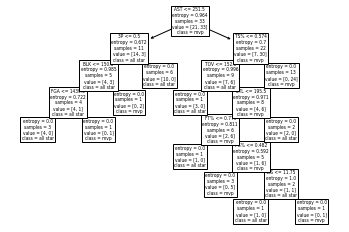

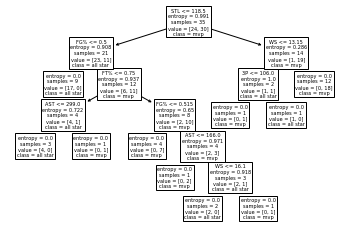

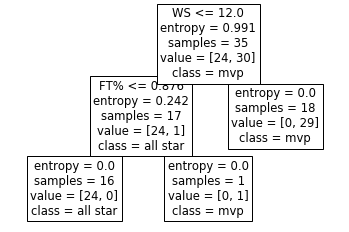

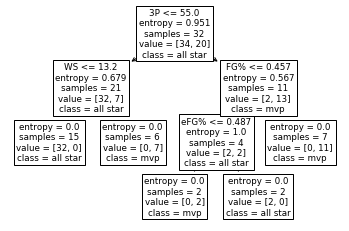

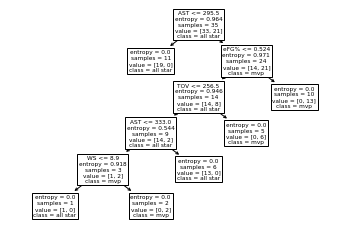

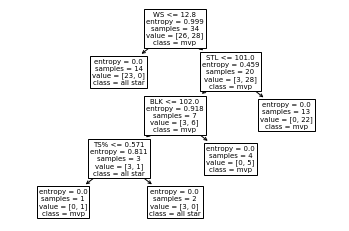

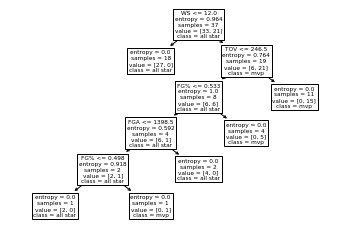

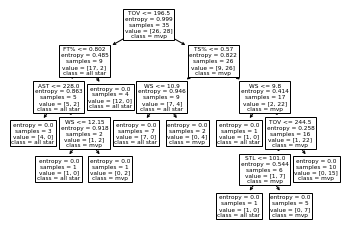

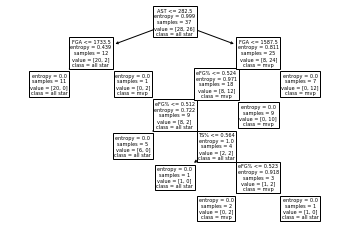

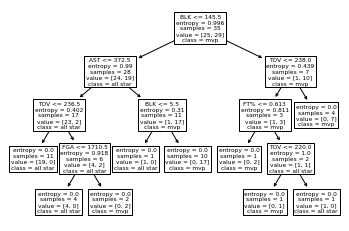

In [7]:
# Visualize
import matplotlib.pyplot as plt
mvp_rf_classifier = RandomForestClassifier(n_estimators=10, criterion='entropy')
mvp_rf_classifier.fit(train_df, train_label)
for tree_in_forest in mvp_rf_classifier.estimators_:
    plt.figure()
    out = plot_tree(tree_in_forest, feature_names=features, class_names=['all star', 'mvp'])

## Conclusion

This is a very basic example and comparison of decision trees with random forests.  There is not really much data to work with (only 39 total examples of MVP seasons) so the gain from the Random Forest classifier is minimal.  However, for larger datasets, a random forest classifier is generally much more effective since it can leverage many uncorrelated decision trees to reduce model variance without significantly increasing bias.  Random forest is often a very good baseline classifier to try on a new dataset.